Final Project Submission

* Student name: Susanna Han
* Student pace: part time
* Scheduled project review date/time: 07/05/2020
* Instructor name: James Irving
* Blog post URL: 

# Introduction

We are building a model that can rate the sentiment of a tweet based on its content. The tweet reviews are on the following products and services.


- IPhone
- Ipad
- Apple Apps (Iphone/Ipad)
- Other Apple product or service 


- Google
- Android
- Android Apps
- Other Google product or service 


Using a Natural Language Processing model allows us to analyze text data, which makes analyzing the score of the 9,093 product tweets possible. Finding the correlation and important features of the positive and negative feedback helps provide insight to the products and services being reviewed. 


The data set we used has three columns which includes the tweet (the review), which product the review is referring to, and whether or not the review was positive, negative, or neutral. 



Below are all libraries and programs used in building our models:

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import regexp_tokenize
from ipywidgets import interact
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image  
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/susannahan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Functions:

In [2]:
def evaluate_model(y_test,y_pred,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False,
                   figsize = (10,4),
                   display_labels=('Not Positive','Positive','Neutral')):
    """
    Arguments needed to evaluate the model are y_test, y_pred, x_test, 
    the model, and display labels.
    
    Evaluate_model prints out the precision, recall, and f1-score score. As well as accuracy, 
    macro average, and weighted average.
    
    Below, a Confusion Matrix visual shows the percentage of how accurate the model fit both predicted and actual
    values. 
    
    """
    ## Classification Report / Scores 
    print(metrics.classification_report(y_test,y_pred))
    # plots Confusion Matrix
    metrics.plot_confusion_matrix(clf,X_test,y_test,cmap="Blues",
                                  normalize='true', 
                                  display_labels = display_labels)
    #plt.title('Confusion Matrix')
    plt.show()

    try: 
        df_important = plot_importance(clf)
    except:
        df_important = None
        

In [3]:
def plot_importance(tree_clf, top_n=20,figsize=(10,8)):
    """ Arguments needed to plot an importance bar graph is the model, number of features to display, and 
    desired figsize for the graph. 
    
    This function displays a bar graph of top 20 important features from most to least important."""
    
    #calculates which feature was used the most in the model.
    df_importance = pd.Series(tree_clf.feature_importances_,vectorizer.get_feature_names())
    
    #sorts 20 important features data in ascending order
    df_importance.sort_values().tail(20).plot(
        kind='barh', figsize=figsize)

    #graph labels
    
    #plt.title('Top Important Features')
    plt.xlabel('Features Importance')
    plt.ylabel('Features')


    plt.show() 

    return df_importance

In [4]:
import tzlocal
import datetime as dt
tz = tzlocal.get_localzone()
print(tz)
start = dt.datetime.now(tz)
print(start.strftime("%m/%d/%Y - %I:%M %p"))
print(dt.datetime.now(tz))

America/Los_Angeles
07/05/2020 - 02:11 AM
2020-07-05 02:11:45.022586-07:00


In [5]:
## a timer to record how long a process takes
class Timer():
 
    ## imports local time and formats displayed time
    def __init__(self,format_="%m/%d/%y - %I:%M %p"):
        import tzlocal
        self.tz = tzlocal.get_localzone()
        self.fmt = format_
        self.created_at = self.get_time()
        
    ## returns current time.
    def get_time(self):
        import datetime as dt
        return dt.datetime.now(self.tz)

    ## displays when time has started.
    def start(self):
        time = self.get_time()
        self.start = time
        print(f"[i] Timer started at{self.start.strftime(self.fmt)}")
        

    ## displays when time has stopped.
    def stop(self):
        time = self.get_time()
        self.end = time
        print(f"[i] Timer ended at {self.end.strftime(self.fmt)}")
        print(f"- Total time = {self.end-self.start}")
timer = Timer()
print(timer.created_at)

2020-07-05 02:11:45.035334-07:00


# Observations

First, we import the data and look through the dataset and make observations of what to change in the dataset to build a good model.

In [6]:
df = pd.DataFrame(pd.read_csv('tweets.csv', encoding = 'unicode_escape'))
#importing the dataset

In [7]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


One of the first observations we see is that the column names are very long and make it more difficult to recall and work with. Therefore, they were modified and renamed to tweets, product, and emotion as shown below.

In [8]:
df.rename(columns = {'tweet_text':'tweets', 'emotion_in_tweet_is_directed_at': 'product', 
              'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweets   9092 non-null   object
 1   product  3291 non-null   object
 2   emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [10]:
df.shape
#shows the shape of our dataframe - 9093 rows and 3 columns.

(9093, 3)

In [11]:
df['emotion'].value_counts(normalize=True)
#shows percentage of each value in column. 
#neutral - 59%
#positive - 33%
#negative - 6%
#unknown - 2%

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [12]:
df['product'].isna().sum()
# 5802 out of 9093 rows are missing product. 

5802

We have decided to keep all missing values in the product column to add more data to the correlation between tweet and emotion. The one missing row from the tweets column is dropped because it adds no value to the dataset.

In [13]:
df['tweets'].dropna(inplace=True)

In [14]:
df['tweets'].isna().sum()

0

In [15]:
#drop I can't tell from column 'emotion'
df.drop(df.loc[df['emotion']=="I can't tell"].index, inplace=True)

In [16]:
df['emotion'].value_counts()
#All "I can't tell" rows has successfully been dropped from the column.

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [17]:
df['emotion'].isnull().sum()

0

In [18]:
df['product'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

# Processing Data

After cleaning out the dataset we started to clean the text in the tweets column to properly train the model to process the text given. First, a variable with all the text in the dataset was created. This is used to make all changes to the text before running it through the model. 

In [19]:
corpus = df['tweets']

In [20]:
corpus[:10]
#glimpse of all the text combined

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
5    @teachntech00 New iPad Apps For #SpeechTherapy...
6                                                  NaN
7    #SXSW is just starting, #CTIA is around the co...
8    Beautifully smart and simple idea RT @madebyma...
9    Counting down the days to #sxsw plus strong Ca...
Name: tweets, dtype: object

We use word_tokenize to separate each word and punctuation to more accurately get rid of empty spaces/words when using stopwords. Stopwords is a list of common words that do not add meaning to a sentence. Bigrams identifies words in pairs which helps in finding sentiment anyalysis. 

In [21]:
tokens = nltk.word_tokenize(','.join(str(v) for v in corpus))
tokens[:10]

['.', '@', 'wesley83', 'I', 'have', 'a', '3G', 'iPhone', '.', 'After']

In [22]:
stopwords_list = stopwords.words('english')
more_punc = ['--',"'",'...','\\','.']
stopwords_list+=string.punctuation
stopwords_list.extend(more_punc)
stopped_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]
bigrams = list(nltk.bigrams(stopped_tokens))

In [23]:
@interact
def tokenize_bigram_text(i=(0,len(corpus)-1)):
  
    ## tokenize text
    print(f"- Tweet #{i}:\n")
    print(corpus[i],'\n')
    tokens = word_tokenize(corpus[i])
    
        
    # Get all the stop words in the English language
    stopwords_list = stopwords.words('english')
    more_punc = ['--',"'",'...','\\','.','%']
    stopwords_list+=string.punctuation
    stopwords_list.extend(more_punc)
    
    stopped_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]
    bigrams = list(nltk.bigrams(stopped_tokens))
    
    print(tokens,'\n\n')
    print(stopped_tokens,'\n\n')
    print(bigrams, end='\n\n')

interactive(children=(IntSlider(value=4468, description='i', max=8936), Output()), _dom_classes=('widget-inter…

Then we figured out the frequency distribution for all the stopped_tokens as well as the bigrams to see the top most common words used in the text.

In [24]:
freq_tokens = FreqDist(stopped_tokens)
freq_tokens.most_common(10)
#frequency of every token

[('sxsw', 9256),
 ('mention', 7016),
 ('link', 4265),
 ('rt', 2926),
 ('google', 2541),
 ('ipad', 2388),
 ('apple', 2263),
 ('quot', 1657),
 ('iphone', 1481),
 ('store', 1447)]

In [25]:
freq_bigrams = FreqDist(bigrams)
freq_bigrams.most_common(10)

[(('rt', 'mention'), 2836),
 (('sxsw', 'link'), 913),
 (('ipad', '2'), 912),
 (('link', 'sxsw'), 810),
 (('sxsw', 'rt'), 633),
 (('mention', 'mention'), 600),
 (('mention', 'sxsw'), 582),
 (('apple', 'store'), 564),
 (('link', 'rt'), 505),
 (('mention', 'google'), 476)]

Regular Expressions is then used to remove or highlight any URLs, hashtags, retweets, and metions that can be misunderstood when being ran through the model. The block of code below gathers all the URLS, hashtags, retweets, and mentions to have a glance at what's in our data.

In [26]:
def urls(string):
    """Finds all URLs from a corpus"""
    string = ','.join(str(v) for v in corpus)
    return re.findall(r"(http[s]?://\w*\.\w*/+\w+)",string) 

def hashtags(string):
    """Finds all hashtags from a corpus"""
    string = ','.join(str(v) for v in corpus)
    return re.findall(r'\#\w*',string)

def retweets(string):
    """Finds all retweets from a corpus"""
    string = ','.join(str(v) for v in corpus)
    return re.findall(r'RT [@]?\w*:',string)

def mentions(string):
    """Finds all mentions from a corpus"""
    string = ','.join(str(v) for v in corpus)
    return re.findall(r'\@\w*',string)

In [27]:
freq_urls = FreqDist(urls(stopped_tokens))
freq_urls.most_common(10)

[('http://bit.ly/hTdFim', 2),
 ('http://bit.ly/guardianapp', 2),
 ('http://ht.ly/49n4M', 1),
 ('http://bit.ly/ieaVOB', 1),
 ('http://bit.ly/gVLrIn', 1),
 ('http://j.mp/grN7pK', 1),
 ('http://bit.ly/aXZwxB', 1),
 ('http://tinyurl.com/4nqv92l', 1),
 ('http://t.co/kfN3f5Q', 1),
 ('http://t.co/g4GZypV', 1)]

In [28]:
freq_mentions = FreqDist(mentions(stopped_tokens))
freq_mentions.most_common(10)

[('@mention', 7006),
 ('@madebymany', 5),
 ('@garyvee', 3),
 ('@Schmittastic', 3),
 ('@jerranalley', 2),
 ('@tbalinas', 2),
 ('@mentionc', 2),
 ('@', 2),
 ('@mentione', 2),
 ('@mentionR', 2)]

In [29]:
freq_hashtags = FreqDist(hashtags(stopped_tokens))
freq_hashtags.most_common(10)

[('#sxsw', 4466),
 ('#SXSW', 4295),
 ('#Apple', 243),
 ('#iPhone', 213),
 ('#sxswi', 208),
 ('#iPad', 182),
 ('#google', 176),
 ('#apple', 170),
 ('#SxSW', 154),
 ('#iPad2', 153)]

In [30]:
freq_retweets = FreqDist(retweets(stopped_tokens))
freq_retweets.most_common(10)

[('RT @malbonster:', 1),
 ('RT @LaurieShook:', 1),
 ('RT UberSoc:', 1),
 ('RT SteveCase:', 1),
 ('RT NicoRiccelli:', 1),
 ('RT VentureBeat:', 1)]

In the code below we are able to find the URLs, hashtags, retweets, and mentions individually on any row. 

In [31]:
def find_urls(string): 
    return re.findall(r"(http[s]?://\w*\.\w*/+\w+)",string)

def find_hashtags(string):
    return re.findall(r'\#\w*',string)

def find_retweets(string):
    return re.findall(r'RT [@]?\w*:',string)

def find_mentions(string):
    return re.findall(r'\@\w*',string)

In [32]:
text = corpus[16]

In [33]:
find_urls(text)

['http://t.co/kfN3f5Q']

Now that our data is cleaned we are able to pre-process the data with the function below. It goes through the steps of finding all the urls, retweets, and hastags and replacing it with spaces, then Lemmatizing the text if necessary. Lemmatization is used to convert the different tenses into the same root word to mean the same thing.As well as detecting and getting rid of the pattern. If the text does not qualify for the adjustments it outputs the tokenized text.  

In [34]:
lemmatizer = WordNetLemmatizer()

In [35]:
def process_tweet(text,as_lemmas=False,as_tokens=True,regex=True):

    for x in find_urls(text):
        text = text.replace(x,'')
        
    for x in find_retweets(text):
        text = text.replace(x,'')    
        
    for x in find_hashtags(text):
        text = text.replace(x,'')  
    
    #for x in find_mentions(text):
        #text = text.replace(x,'')

    if as_lemmas:
        from nltk.stem.wordnet import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        text = lemmatizer.lemmatize(text)
    
    if regex:
        pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
        tokens= regexp_tokenize(text,pattern)
    else:
        tokens = word_tokenize(text)
    
    if len(text)==0:
        text=''
            
    return text

In [36]:
@interact
def show_processed_tweet(i=(0,len(corpus)-1)):
    text_in = corpus[i]#.copy()
    print(text_in,'\n')
    text_out = process_tweet(text_in)
    print(text_out,'\n')
    text_out2 = process_tweet(text_in,as_lemmas=True)
    print(text_out2)

interactive(children=(IntSlider(value=4468, description='i', max=8936), Output()), _dom_classes=('widget-inter…

A target column was created that indicated the tweet expressed a Positive emotion. Another column was created for tweets that had no emotion toward brand or product.

In [37]:
#add a target column where the emotion toward the product is positive. 
df['target'] = (df['emotion'] == 'Positive emotion').astype(int)
df['neutral'] = (df['emotion'] == 'No emotion toward brand or product').astype(int)
df.head()

,tweets,product,emotion,target,neutral
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1,0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1,0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1,0


# Base Model


In [38]:
y = df['emotion'].copy()
X = df['tweets'].copy()

In [39]:
X_train,X_test, y_train,y_test = train_test_split(X,y,stratify=y,random_state=45)

We can see that the data was evenly distributed between both the train and test sets. 

In [40]:
y_train.value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333184
Negative emotion                      0.063862
Name: emotion, dtype: float64

In [41]:
y_test.value_counts(normalize=True)

No emotion toward brand or product    0.603132
Positive emotion                      0.333333
Negative emotion                      0.063535
Name: emotion, dtype: float64

In [42]:
X_train.isna().sum()

1

In [43]:
X_train.fillna('',inplace=True)

In [44]:
X_train.isna().sum()

0

In [45]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False,)

In [46]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,stop_words=stopwords_list)
vectorizer

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb9a7c8d5c0>>)

In [47]:
X_train_tfidf = vectorizer.fit_transform(X_train).astype(float)
X_test_tfidf = vectorizer.transform(X_test).astype(float)

In [48]:
X_train_tfidf.shape
#(tweets, words)

(6702, 9130)

In [49]:
## Make, fit model
base_tree = RandomForestClassifier(class_weight='balanced')
base_tree.fit(X_train_tfidf,y_train)

RandomForestClassifier(class_weight='balanced')

In [50]:
## Get predictions
y_hat_train = base_tree.predict(X_train_tfidf)
y_hat_test =  base_tree.predict(X_test_tfidf)

                                    precision    recall  f1-score   support

                  Negative emotion       1.00      1.00      1.00       428
No emotion toward brand or product       1.00      0.99      1.00      4041
                  Positive emotion       0.99      1.00      0.99      2233

                          accuracy                           1.00      6702
                         macro avg       1.00      1.00      1.00      6702
                      weighted avg       1.00      1.00      1.00      6702



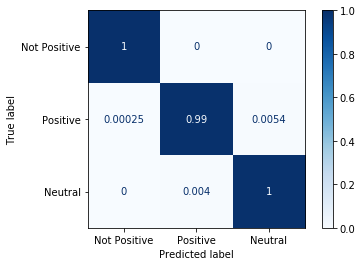

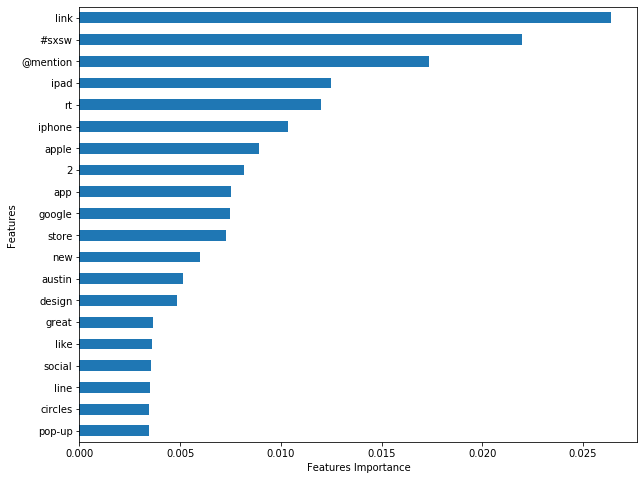

In [51]:
## Evaluate Model - Training Data
evaluate_model(y_train, y_hat_train, X_train_tfidf, base_tree)

                                    precision    recall  f1-score   support

                  Negative emotion       0.75      0.17      0.28       142
No emotion toward brand or product       0.70      0.89      0.78      1348
                  Positive emotion       0.66      0.43      0.52       745

                          accuracy                           0.69      2235
                         macro avg       0.70      0.50      0.53      2235
                      weighted avg       0.69      0.69      0.66      2235



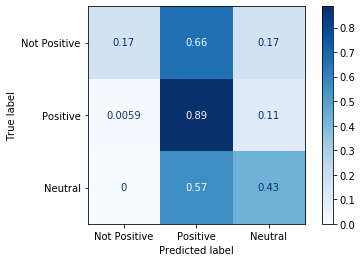

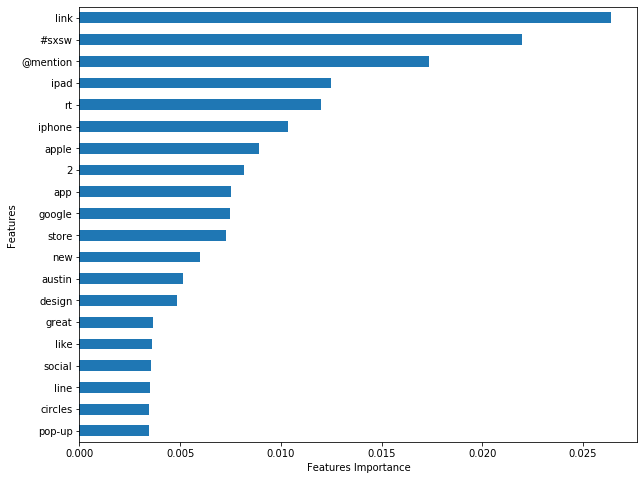

In [52]:
evaluate_model(y_test, y_hat_test, X_test_tfidf, base_tree)

In [53]:
display(base_tree.score(X_train_tfidf, y_train))
display(base_tree.score(X_test_tfidf, y_test))

0.9952253058788422

0.6894854586129754

The base model has an accuracy of 69%

# Best Model

In [ ]:
#how to used preprocessed data

In [81]:
#tokenize_bigram_text.head()

In [ ]:
#tokenize_bigram_text.isna().sum()
#tokenize_bigram_text.fillna('',inplace=True)
#tokenize_bigram_text.isna().sum()

In [ ]:
#y = df['emotion'].copy()
#X = df['tweets'].copy()

In [ ]:
#X_train,X_test, y_train,y_test = train_test_split(X,y,stratify=y,random_state=45)

In [55]:
y = df['emotion'].copy()
X = df['tweets'].copy()

In [56]:
X_train,X_test, y_train,y_test = train_test_split(X,y,stratify=y,random_state=45)

In [59]:
y_train.value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333184
Negative emotion                      0.063862
Name: emotion, dtype: float64

In [60]:
y_test.value_counts(normalize=True)

No emotion toward brand or product    0.603132
Positive emotion                      0.333333
Negative emotion                      0.063535
Name: emotion, dtype: float64

In [66]:
X_train.fillna('',inplace=True)
X_train.isna().sum()

0

In [61]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False,)

In [62]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,stop_words=stopwords_list)
vectorizer

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb99988f780>>)

In [67]:
X_train_tfidf = vectorizer.fit_transform(X_train).astype(float)
X_test_tfidf = vectorizer.transform(X_test).astype(float)

In [69]:
best_tree = RandomForestClassifier(class_weight='balanced')
best_tree.fit(X_train_tfidf,y_train)

RandomForestClassifier(class_weight='balanced')

In [70]:
rf_random = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': ['gini','entropy']}

In [71]:
rf_tree = RandomizedSearchCV(estimator = rf_random, 
                             param_distributions = random_grid, 
                             n_iter = 50,cv = 3, verbose=2, 
                             random_state=42, n_jobs = -1)

In [72]:
timer = Timer()
timer.start()

rf_tree.fit(X_train_tfidf, y_train)
timer.stop()

[i] Timer started at07/05/20 - 02:17 AM
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


[i] Timer ended at 07/05/20 - 02:20 AM
- Total time = 0:02:33.626081


In [73]:
display(rf_tree.best_params_)

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'criterion': 'gini',
 'bootstrap': False}

In [74]:
best_tree = rf_tree.best_estimator_
#tree with best params
y_hat_test = best_tree.predict(X_test_tfidf)
#predictions

                                    precision    recall  f1-score   support

                  Negative emotion       1.00      1.00      1.00       428
No emotion toward brand or product       1.00      0.99      1.00      4041
                  Positive emotion       0.99      1.00      0.99      2233

                          accuracy                           1.00      6702
                         macro avg       1.00      1.00      1.00      6702
                      weighted avg       1.00      1.00      1.00      6702



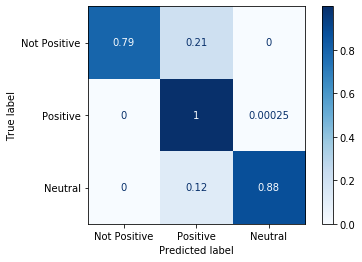

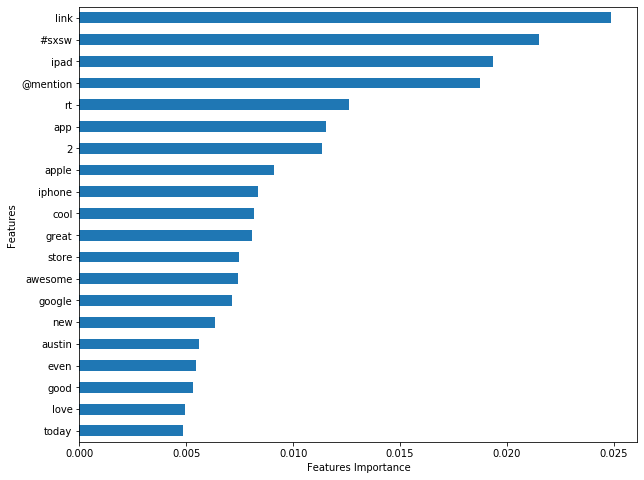

In [75]:
evaluate_model(y_train, y_hat_train, X_train_tfidf, best_tree)

                                    precision    recall  f1-score   support

                  Negative emotion       0.95      0.13      0.23       142
No emotion toward brand or product       0.70      0.92      0.80      1348
                  Positive emotion       0.70      0.43      0.54       745

                          accuracy                           0.71      2235
                         macro avg       0.79      0.50      0.52      2235
                      weighted avg       0.72      0.71      0.67      2235



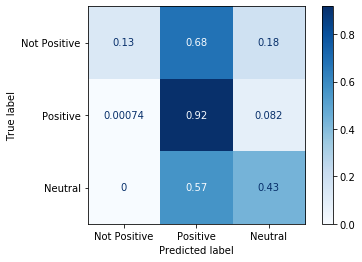

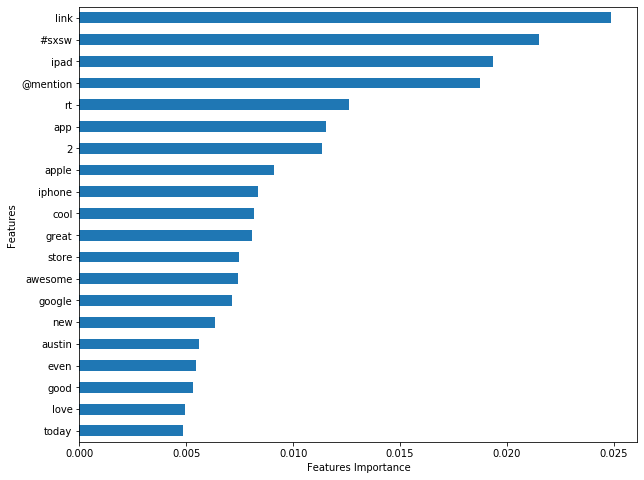

In [76]:
evaluate_model(y_test, y_hat_test, X_test_tfidf, best_tree)

In [77]:
display(best_tree.score(X_train_tfidf, y_train))
display(best_tree.score(X_test_tfidf, y_test))

0.9474783646672635

0.7064876957494407

The best model has an accuracy of 71%

# Results

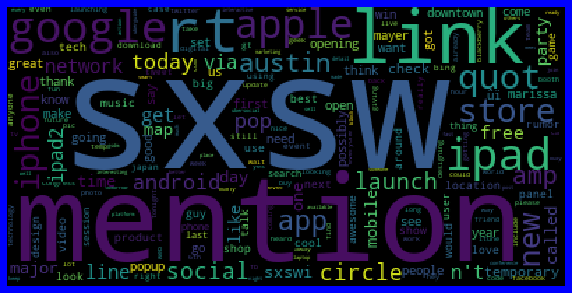

In [78]:
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (10, 12), facecolor = 'blue', edgecolor = 'blue') 
plt.imshow(wordcloud) 
plt.axis('off');

# Conclusion